<a href="https://colab.research.google.com/github/datawiz1984/malaria-model/blob/master/malaria_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Colab Jupyter Note book for the Implementation of a Malaria Diagnostic Tool.**
By Musa Mikail
July 2019.

The Aim of the Book is to Train a Binary Classifer that will be used in diagonising malaria using images captured from a  thin-smear test. 

Its a partial requirment for the fulfilment of the Machine LEarning Nanodegree with Udacity.

The Implementation will be progressed thus:

1. Download the Malaria Dataset from https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip.
2. Explore and analyse the data to identify the key features and ascertain additional pre-processing requirments before progressing with training.
3. Pre-process the data - Including resampling and aurgumentation where required.
4. Implement and train a Convolution Neural Network for Binary classification of the cell images.
5. Implement a vanilla ANN for the purpose of benchmarking and pefromance assessment
6. Save and export model for deployment.
7.Additionally, Implement a Canny Edge detection method for counting and segmentation of cells from images passed for inference (not related to model training)


**1. Download the Malaria Dataset from https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip.**

In [1]:
#Download data from the website of US national library of medicine
import os

if not os.path.isdir('/datasets/malaria/'):
  os.makedirs('/datasets/malaria/')

!wget --no-check-certificate "https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip" \
-O /datasets/malaria/cell_images.zip

--2019-07-26 04:17:56--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘/datasets/malaria/cell_images.zip’

/datasets/malaria/c 100%[===================>] 337.08M  57.4MB/s    in 4.7s    

2019-07-26 04:18:02 (71.4 MB/s) - ‘/datasets/malaria/cell_images.zip’ saved [353452851/353452851]



In [2]:
import zipfile

zip_path = '/datasets/malaria/cell_images.zip'
print('Unzipping file....')
malaria_zip = zipfile.ZipFile(zip_path,'r')
malaria_zip.extractall('/datasets/malaria/')
malaria_zip.close()
print('Done!!!')

Unzipping file....
Done!!!


**Explore and analyse the data **

In [3]:
#Check the distribution of the training data - viz a viz No. in each category.
train_parasitized_dir = '/datasets/malaria/cell_images/Parasitized'

#Diectory with our training Uninfected cells pictures
train_uninfected_dir = '/datasets/malaria/cell_images/Uninfected'

train_parasitized_names = os.listdir(train_parasitized_dir)
train_uninfected_names = os.listdir(train_uninfected_dir)
print('total training parasitized images:', len(os.listdir(train_parasitized_dir)))
print('total training Uninfected images:', len(os.listdir(train_uninfected_dir)))

total training parasitized images: 13780
total training Uninfected images: 13780


File skipped: /datasets/malaria/cell_images/Parasitized/Thumbs.db
File skipped /datasets/malaria/cell_images/Uninfected/Thumbs.db
Modal Height of Image: 130
Modal Width of Image: 130
Stand. Dev Height of Image: 20.61927561732627
Stand. Dev Width of Image: 20.015585545533767


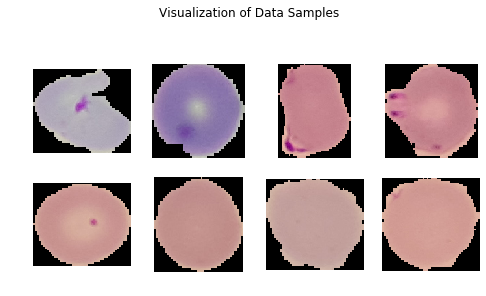

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


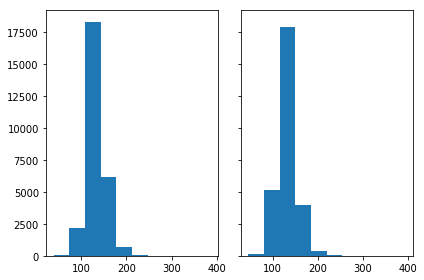

In [4]:
#Conduct some visual analysis of the dataset to identify any common feature
#And any additional processing that will be required.
%matplotlib inline

import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.image as mpimg
from PIL import Image
from statistics import mode,pstdev

#Get the dimensions of the images
img_heights=[]
img_widths=[]

#Index for image iteration
pic_print_index = 4


#parameters for 2X2 graphs

nrows = 4
ncols = 4


# Set up matplotlib fig, and size it to fit 2X2 pics
fig1 = plt1.gcf()
fig1.set_size_inches(ncols * 2, nrows * 2)
fig1.suptitle('Visualization of Data Samples')


next_parasitized_pix = [os.path.join(train_parasitized_dir, fname) 
                for fname in train_parasitized_names]

next_Uninfected_pix = [os.path.join(train_uninfected_dir, fname) 
                for fname in train_uninfected_names]

for f in next_parasitized_pix:
  try:
    img = Image.open(str(f))
    img_heights.append(img.height)
    img_widths.append(img.width)
  except:
    print("File skipped: {}".format(str(f)))
    
for f in next_Uninfected_pix:
  try:
    img = Image.open(str(f))
    img_heights.append(img.height)
    img_widths.append(img.width)
  except:
    print("File skipped {}".format(str(f)))

#print(img_heights[0])

  
#print sample images of both classes in the training data

for i, img_path in enumerate(next_parasitized_pix[0:pic_print_index]+next_Uninfected_pix[0:pic_print_index]):
  # Set up subplot; subplot indices start at 1
  sp = plt1.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt1.imshow(img)

  
fig1, axs = plt2.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(img_heights)
axs[1].hist(img_widths)
  
#Plot distribution of Height and width
print("Modal Height of Image: {}".format(mode(img_heights)))
print("Modal Width of Image: {}".format(mode(img_widths)))
print("Stand. Dev Height of Image: {}".format(pstdev(img_heights)))
print("Stand. Dev Width of Image: {}".format(pstdev(img_widths)))

***Observations from Data Exploration:***
1. There are a total of 27,560 Images in the training dataset
2. The Training data is balanced (equal number of classes), and Accuracy will be a good metrics for measuring performance during training.
3. There is a variations in the shapes of the images, with 130X130 been the most common occurence with variance of  observed.

**3. Pre-process the data - Including resizing, and Aurgumentation** **bold text**

In [5]:
#Data Processing using the image generator
#Detailed guide on the use of the ImageDataGenerator is
#available at:
#www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#Images pixel intensities normalized, rescaled by 1./255
#This dimension was selected around the mode dimension for anti-aliasing.
#The training dataset was split into training (75%) & validation (25%) datasets.
#The training data was augmented by applying the following to each image:
#  o	Random rotations, with 20⁰ as the rotation threshold.
#  o	A width and height shift limited to 20% of the actual.
#  o	Flipping along the horizontal axis.


image_gen= ImageDataGenerator(rescale = 1./255,
                             validation_split = 0.25,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

#Flow the whole data in batches of 128 using data_gen generator
#The images in the dataset were resampled to a uniform dimension of 130X130 px.
#For comformity with the input layer of the CNN

train_data = image_gen.flow_from_directory(
    '/datasets/malaria/cell_images/',
     target_size = (130,130),
     batch_size = 128,
     class_mode = 'binary')

test_data = image_gen.flow_from_directory(
    '/datasets/malaria/cell_images/',
     target_size = (130,130),
     batch_size = 128,
     class_mode = 'binary')

Found 27558 images belonging to 2 classes.
Found 27558 images belonging to 2 classes.


In [6]:
#Build a Refercnce model to support benchmarking
#Model refered to as "Reference model" in the report

transformVanilla = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(130, 130, 3)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

W0726 04:18:17.790928 140154752845696 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
#The "Deployed model" is based on a CNN.
# Final selected model parameters for the network are indicated accordingly.

transformLightCNN = tf.keras.models.Sequential([
    #Stage 1
    tf.keras.layers.Conv2D(16, (3,3), strides=(1,1), activation = 'relu', input_shape = (130,130,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    #Stage 2
    tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Stage 3
    tf.keras.layers.Conv2D(64, (3,3), strides=(1,1), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Fully Connected Section
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [0]:
#Implement Training Callbacks

vanilla_train_loss=[]
vanilla_train_acc = []
vanilla_validation_loss = []
vanilla_validation_acc = []
light_train_loss=[]
light_train_acc = []
light_validation_loss = []
light_validation_acc = []


class vanillaCallback(tf.keras.callbacks.Callback):
  def on_train_batch_end(self, epoch, logs={}):
    vanilla_train_loss.append(logs.get('loss'))
    vanilla_train_acc.append(logs.get('acc'))
    vanilla_validation_loss.append(logs.get('val_loss'))
    vanilla_validation_acc.append(logs.get('val_Acc'))


class lightCallback(tf.keras.callbacks.Callback):
  def on_train_batch_end(self, epoch, logs={}):
    light_train_loss.append(logs.get('loss'))
    light_train_acc.append(logs.get('acc'))
    light_validation_loss.append(logs.get('val_loss'))
    light_validation_acc.append(logs.get('val_Acc'))

    
vanilla_callbacks = vanillaCallback()
Light_callbacks = lightCallback()


In [9]:
# Training Parameters:
# • Loss function: Binary crossentropy
# •	Optimizer: Adaptive moment estimation (Adam)
# •	Metrics: Accuracy - appropriate as training data is balanced.

transformVanilla.compile(loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['acc'])

transformLightCNN.compile(loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['acc'])

W0726 04:18:18.143002 140154752845696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#Training of the Vanilla MLP Classifier
%%timeit
transformerVanilla = transformVanilla.fit_generator(
            train_data,
            callbacks=[vanilla_callbacks],
            validation_data=test_data,
            validation_steps=8,
            epochs=10,
            verbose=1)

Epoch 1/10
130/216 [=================>............] - ETA: 56s - loss: 6.5581 - acc: 0.5450

In [0]:
#Training of the Tuned Light architecture Classifier
%%timeit
transformerLightCNN = transformLightCNN.fit_generator(
            train_data,
            callbacks=[Light_callbacks],
            validation_data=test_data,
            validation_steps=8,
            epochs=10,
            verbose=1)

In [0]:
#Summary of Built models
transformVanilla.summary()
transformLightCNN.summary()

In [0]:
def cells_counter(pt):
  #Import relevant libraries
  from keras.preprocessing import image
  import cv2
  from google.colab.patches import cv2_imshow
  import numpy as np
  
  count_inf = 0 #Total number of cells predicted to be infected.
  count = 0 # Total numbe rof cells on the slide.
  
  slide = cv2.imread(str(pt)) # A quick view of the slide
  
  #Convert the RGB slide image to Grayscale.
  #This enhances the areas of varying intensities in the images
  #And improve the accuracy of the next stage
  gray=cv2.cvtColor(slide,cv2.COLOR_BGR2GRAY)
  
  #Identify the edges of the red blood cells using the Canny filter.
  slide_edged=cv2.Canny(gray, 30, 200, 3, L2gradient=True)
  cv2.waitKey(0)
  
  #create contours around the edges of the cells
  #each contour represent the bounded area around a separet red blood cell.
  _, contours, hierarchy=cv2.findContours(slide_edged,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
  cv2.waitKey(0)
  
  #setting the 3rd parameter to -1 draw the contours for visualization
  cv2.drawContours(slide,contours,-1,(25,0,0),1)
  cv2_imshow(slide)
  
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  print('Total contours', str(len(contours))) #this support debugging.
  
  if not os.path.isdir('./temp_cells'):
    os.makedirs('./temp_cells')
  temp_file = "./temp_cells/current_file"
  #Iterate over individal contours to create images and perform inference on it
  for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    if (w/h > 0.8 and w/h < 1.1):
      #use the bound box around the contours to create separate image files
      #for each segmented cell
      cell_img=slide[y:y+h,x:x+w]
      #temporary create the file containing the cell for inference making
      cv2.imwrite(temp_file + '.png', cell_img)
      img = image.load_img(temp_file + '.png', target_size=(130, 130))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      cell = np.vstack([x])
      #Pass the cell image into the "Deployment model" for prediction
      health = transformLightCNN.predict(cell, batch_size=10)
      if health[0] < 0.5:
        #print("Is  Infected")
        count_inf = count_inf + 1
      #else:
      #  print("Is not Infected")
      print('prediction is {}'.format(health[0]))
      #cell_temp = cv2.imread(temp_file + '.png')
      #cv2_imshow(cell_temp)
      cv2.waitKey(1)
  return count_inf, len(contours)

In [0]:
#Run this and upload an image of a slide
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  #This will call the above function:cells_counter to predict
  infected,total = cells_counter(path)
  print (str(infected/total))

In [0]:
#Visual analysis of the model performance
from matplotlib import pyplot as plt3
lightx = range(len(light_train_acc))
vanillax = range(len(vanilla_train_acc))
plt3.plot(lightx,light_train_acc,label='Deployed Model')
plt3.plot(vanillax,vanilla_train_acc,label='Reference Model')
plt3.legend()
plt3.title('Training Accuracy against Training Cycle')
plt3.ylabel('Training Accuracy (pu)')
plt3.xlabel('Training Cycle')

In [0]:
#Save models in hdf5 format for export and deployment.
transformLightCNN.save('transformLightCNN.h5')
transformVanilla.save('transformVanilla.h5')